In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.model_selection import train_test_split

from customnet import CustomNet

import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')     
%matplotlib inline

import pandas as pd

import numpy as np
from imutils import paths, resize
import cv2

## 1. Load the MNIST dataset.

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

### 1.1 Visualize datapoint samples.

In [4]:
X_train.shape

(60000, 28, 28)

In [5]:
X_test.shape

(10000, 28, 28)

As we can see, we've got 60000 samples in our training set and 10000 samples in our testing set.

Each image, or sample, or datapoint has a dimension of (28, 28) and belongs to the gray-scale color-space, so their depth equals 1.

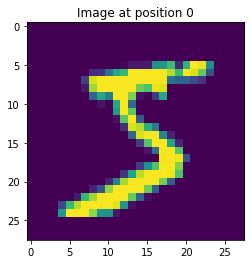

In [12]:
plt.imshow(X_train[0])
plt.title(label='Image at position 0')
plt.show()

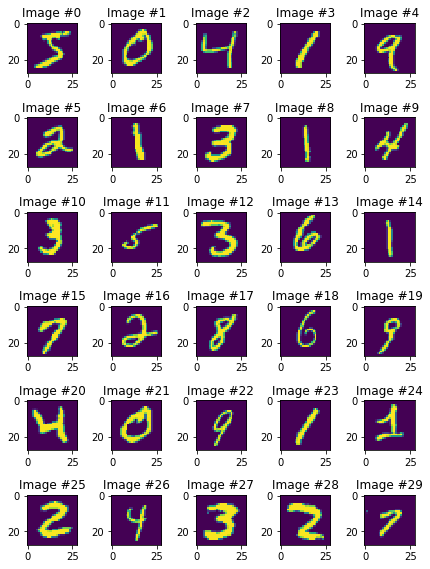

In [7]:
fig, ax = plt.subplots(
    nrows=6,
    ncols=5,
    figsize=[6, 8]
)

for index, axi in enumerate(ax.flat):
    axi.imshow(X_train[index])
    axi.set_title(f'Image #{index}')

plt.tight_layout(True)
plt.show()

As you can see, images in the MNIST dataset are heavily pre-processed. That's why this is used as a benchmark dataset and getting very high accuracy is common. In a real-world problem, we'll need to do some image pre-processing to enchance images and extract meaningful features.

## 2. Normalize pixel intensities to range [0, 1]

In [8]:
(X_train, X_test) = (child.astype('float32') / 255.0 for child in [X_train, X_test])

Normalization of pixel intensities is adjusting values measured on different scales to a notionally common scale.
That's a best practice you have to follow because, in that scenario, weights reach optimum values faster. Therefore, the network converges faster.

So, instead of having pixel intensities in the range [0, 255] in the gray-scale color-space, we're going to scale them into the range [0, 1]. There are many normalization techniques and this is one of them.

## 3. One-Hot Encode labels

In [9]:
pd.DataFrame(y_train)

,0
0,5
1,0
2,4
3,1
4,9
...,...
59995,8
59996,3
59997,5
59998,6


There are 60000 integers labels for the training set, each one corresponding to one single datapoint. That means, for a given Xi datapoint we got a Yi label in the range [0, 9]. For instance, the datapoint at the index 59995 of our training set has the label 8. We can confirm this when plotting the datapoint.

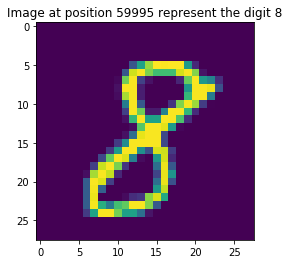

In [10]:
plt.imshow(X_train[59995])
plt.title(label='Image at position 59995 represent the digit 8')
plt.show()

In [11]:
lb = LabelBinarizer()
(y_train, y_test) = (lb.fit_transform(labels) for labels in [y_train, y_test])
pd.DataFrame(y_train)

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
59995,0,0,0,0,0,0,0,0,1,0
59996,0,0,0,1,0,0,0,0,0,0
59997,0,0,0,0,0,1,0,0,0,0
59998,0,0,0,0,0,0,1,0,0,0


Now, our previous integer labels are converted to **vector labels**. This process is called *one-hot encoding* and most of the machine learning algorithms benefit from this label representation. **2 = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]**, **8 = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]**.

We could also use the **to_categorical()** function from Keras which yields the exact same values.

## 4. Data Augmentation

Let's apply some data augmentation. Data augmentation is a set of techniques used to generate new training samples from the original ones by applying jitters and perturbations such that the classes labels are not changed. In the context of computer vision, these random transformations can be translating, rotating, scaling, shearing, flipping etc.

Data augmentation is a form of regularization because the training algorithm is being constantly presented with new training samples, allowing it to learn more robust and discriminative patterns and reducing overfitting.

In [184]:
daug = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range = 0.1, 
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

Todo:
- [X] Build neural net (model)
- [X] Choose optimizer
- [X] Talk about learning rate, callbacks
- [X] Train/Evalute

## 5. Build a neural net model 

In [15]:
net = CustomNet()
model = net.build(width=28, height=28, num_classes=10, depth=3)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 64)        1792      
_________________________________________________________________
activation_8 (Activation)    (None, 28, 28, 64)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
activation_9 (Activation)    (None, 28, 28, 64)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 64)       

Here, we've imported our CNN. That's a small VGG-like net, with two stacks of (Conv => ReLU => BN) * 2 => POOL => DO and a Fully-Connected layer at the end. Pay attention to Batch Normalization and Dropout layers which help to reduce overfitting.

## 6. Set the optimizer and hyperparameters

In [28]:
num_epochs = 50

When the model has seen all of your training samples, we say that one epoch has passed. We're going to train the model for 50 epochs.

In [29]:
# Initial learning rate
init_lr = 0.001

adam_opt = Adam(
    lr=init_lr,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-08,
    decay=0.0
)

Let's use an optimization method.

Optimization algorithms are the engines that power neural networks and enable them to learn patterns from data by tweaking and seeking for optimal weights values. Most common one is the (Stochastic) Gradient Descent, but I'll use Adam here.

As you can see, the first param is lr, or learning rate. This is one of the most important hyperparameters we have to tune. A learning rate is the step your optimization algorithm is going to make toward the direction that leads to a lower loss function (and a higher accuracy). 

If the learning rate is too small, the algorithm is going to make tiny steps slowing down the process. But on the other hand, if the learning rate is too high, the algorithm risks to bounce around the loss landscape and not actually “learn” any patterns from your data.

In [30]:
def polynomial_decay(epoch):
    max_epochs = num_epochs
    base_lr = init_lr
    power = 2.0
    
    return base_lr * (1 - (epoch / float(max_epochs))) ** power

Let's now define a learn-rate scheduler.

The decay is used to slowly reduce the learning rate over time. Decaying the learning rate is helpful in reducing overfitting and obtaining higher classification accuracy – the smaller the learning rate is, the smaller the weight updates will be. We're going to use a polynomial decay. Although there are many way to do that.

Let's plot it.

$$\alpha = \alpha_{0} * (1 - e / e_{\max})^{^{p}}$$

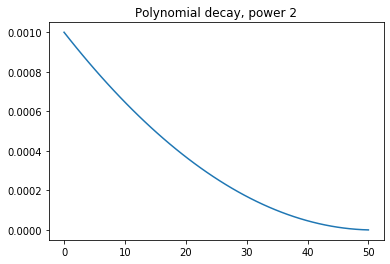

In [44]:
x = np.linspace(0, num_epochs)
fx = [init_lr * (1 - (i / float(num_epochs))) ** 2.0 for i in range(len(x))]
plt.plot(x, fx)
plt.title(label='Polynomial decay, power 2')
plt.show()

## 7. Compile and fit!

In [187]:
checkpointHandler = ModelCheckpoint(
    'best_c10_weights.hdf5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks = [
    LearningRateScheduler(polynomial_decay),
    checkpointHandler
]

Here, we define two callbacks. Callbacks are functions executed at the end of an epoch. The first one save our model (checkpoint) whenever the loss decreases (therefore our accuracy improves). That way we keep the best model. The last one is our learning rate scheduler using the polynomial decay.

In [45]:
print('# Compiling the model...')
model.compile(
    loss='categorical_crossentropy',
    optimizer=adam_opt,
    metrics=['accuracy']
)

print('# Training the network...')
h = model.fit_generator(
    daug.flow(trainX, trainY, batch_size=128),
    validation_data=(testX, testY),
    epochs=num_epochs,
    steps_per_epoch=len(trainX) // 128,
    callbacks=callbacks,
    verbose=1
)

# Compiling the model...
# Training the network...
Epoch 1/50
467/468 [============================>.] - ETA: 0s - loss: 0.1877 - acc: 0.9440
Epoch 00001: val_loss improved from inf to 11.49225, saving model to best_c10_weights.hdf5
468/468 [==============================] - 45s 96ms/step - loss: 0.1875 - acc: 0.9440 - val_loss: 11.4923 - val_acc: 0.1093
Epoch 2/50
467/468 [============================>.] - ETA: 0s - loss: 0.0762 - acc: 0.9767
Epoch 00002: val_loss improved from 11.49225 to 0.05709, saving model to best_c10_weights.hdf5
468/468 [==============================] - 40s 87ms/step - loss: 0.0761 - acc: 0.9767 - val_loss: 0.0571 - val_acc: 0.9826
Epoch 3/50
467/468 [============================>.] - ETA: 0s - loss: 0.0589 - acc: 0.9826
Epoch 00003: val_loss improved from 0.05709 to 0.05332, saving model to best_c10_weights.hdf5
468/468 [==============================] - 41s 87ms/step - loss: 0.0589 - acc: 0.9826 - val_loss: 0.0533 - val_acc: 0.9852
Epoch 4/50
467/468 [======

## Evalute the network

In [46]:
label_names = [
    '0',
    '1',
    '2',
    '3',
    '4',
    '5',
    '6',
    '7',
    '8',
    '9'
]

print('# Trained the network! Evaluating...')
preds = model.predict(testX, batch_size=128)
print(classification_report(testY.argmax(axis=1),
preds.argmax(axis=1), target_names=label_names))

# Trained the network! Evaluating...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      1.00      1.00      1032
           3       0.99      1.00      1.00      1010
           4       0.99      0.99      0.99       982
           5       1.00      0.99      0.99       892
           6       1.00      1.00      1.00       958
           7       1.00      1.00      1.00      1028
           8       1.00      1.00      1.00       974
           9       0.99      0.99      0.99      1009

   micro avg       1.00      1.00      1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



## 8. Visualize curves!

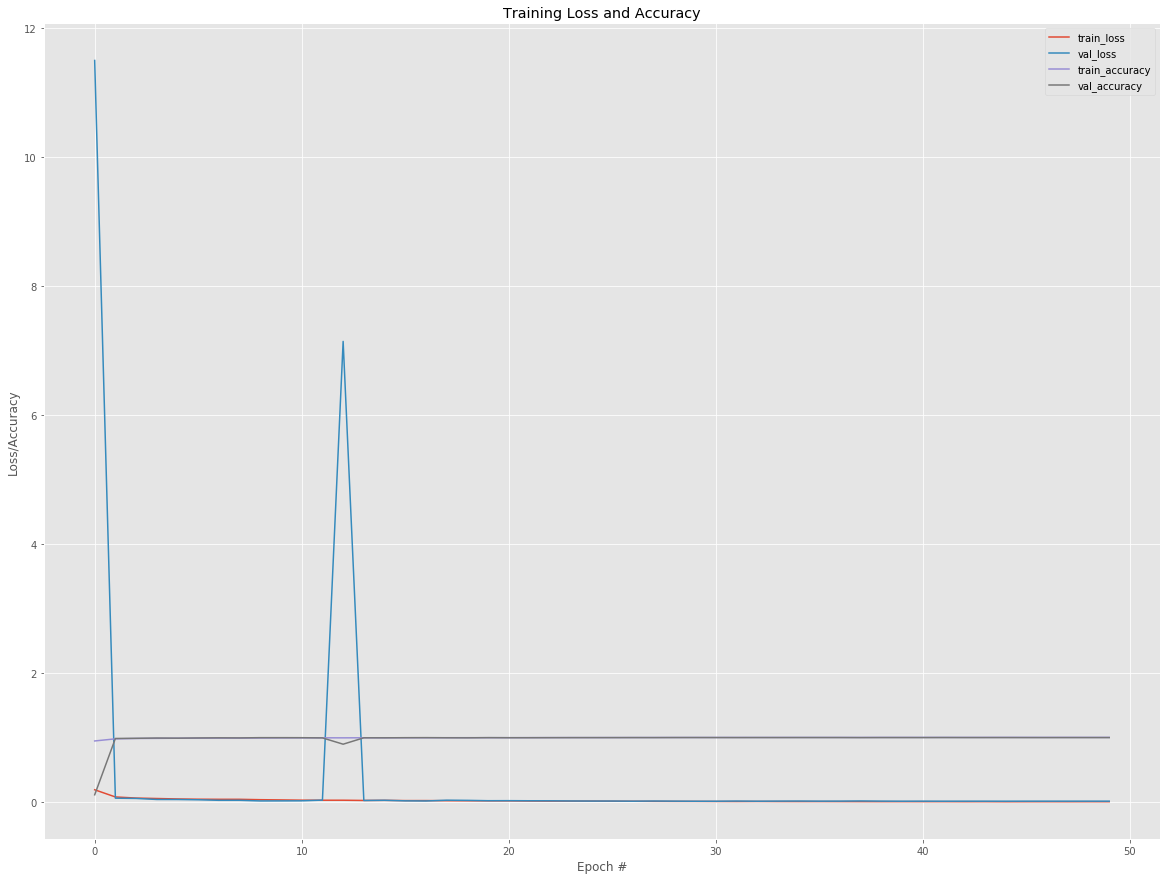

In [47]:
plt.style.use('ggplot')
plt.plot(np.arange(0, num_epochs), h.history['loss'], label='train_loss')
plt.plot(np.arange(0, num_epochs), h.history['val_loss'], label='val_loss')
plt.plot(np.arange(0, num_epochs), h.history['acc'], label='train_accuracy')
plt.plot(np.arange(0, num_epochs), h.history['val_acc'], label='val_accuracy')

plt.title('Training Loss and Accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch #')
plt.legend()

plt.show()

## (Optional) Generate a submission, Kaggle

In [48]:
test = pd.read_csv("test.csv")
test = test / 255.0
test = test.values.reshape(-1,28,28,1)
results = model.predict(test)
results = np.argmax(results, axis=1)
results = pd.Series(results, name='Label')
submission = pd.concat([pd.Series(range(1,28001), name='ImageId'), results], axis=1)
submission.to_csv('cnn_mnist_datagen.csv', index=False)
print("Saved!")

Saved!
